In [4]:
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.ticker as mticker
from dotenv.main import load_dotenv
import os

load_dotenv(override=True)

True

## Plotting compliance

You can choose between plotting average portfolio in each portfolio, or all of them.

In [5]:
df = pd.read_csv('../../data/final_daily_returns_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [6]:
frac_liabilities = float(os.getenv('FRAC_LIABILITIES'))

In [7]:
def load_pareto_fronts(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    all_runs = []
    for entry in data:
        pareto_front = []
        for solution in entry.get("solutions", []):
            # Ensure solution is a dictionary
            if isinstance(solution, dict):
                pareto_front.append({
                    "weights": solution.get("weights", []),
                    "expected_return": solution.get("expected_return", 0),
                    "SCR_risk": solution.get("SCR_risk", 0),
                    "risk_measure": solution.get("risk_measure", ""),
                    "distribution": solution.get("distribution", ""),
                    "period": solution.get("period", [])
                })
        all_runs.append(pareto_front)
    return all_runs

json_file_path = "../pareto_front_results.json"
pareto_fronts = load_pareto_fronts(json_file_path)
len(pareto_fronts[0])

47

In [8]:
def average_weights_pareto_fronts(pareto_fronts):
    averaged_pareto_fronts = []

    for pareto_front in pareto_fronts:
        # Extract all weights from the solutions in the Pareto front
        all_weights = np.array([solution["weights"] for solution in pareto_front])
        
        if len(all_weights) > 0:  # Ensure there are solutions to average
            # Compute the average weights
            avg_weights = np.mean(all_weights, axis=0)
        else:
            avg_weights = []

        # Create a new Pareto front with averaged weights
        averaged_pareto_front = []
        solution = pareto_front[0]
        new_solution = solution.copy()
        new_solution["weights"] = avg_weights.tolist()  # Convert numpy array back to list
        averaged_pareto_front.append(new_solution)
        
        averaged_pareto_fronts.append(averaged_pareto_front)

    return averaged_pareto_fronts


In [9]:
def risk_averse_portfolios(pareto_fronts):
    risk_averse_portfolios = []

    for pareto_front in pareto_fronts:

        portfolio = min(pareto_front, key=lambda portfolio: portfolio['SCR_risk'])
        least_risk_portfolio = [portfolio]
        risk_averse_portfolios.append(least_risk_portfolio)
    return risk_averse_portfolios

In [10]:
pareto_fronts1 = average_weights_pareto_fronts(pareto_fronts)
pareto_fronts = risk_averse_portfolios(pareto_fronts)

print(pareto_fronts)

print(pareto_fronts1)

[[{'weights': [0.044886437786829485, 0.013451798375490097, 0.08520952800352115, 0.21635385043146177, 0.2017248163822369, 0.15688083797134128, 0.2814727898320712], 'expected_return': 42064.306689487894, 'SCR_risk': 260716.1362082518, 'risk_measure': 'cvar', 'distribution': 'tstudent', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [6.422813436850693e-05, 0.05416933912586052, 0.1294925478985313, 0.1551846220795404, 0.30173855190530124, 0.1180076599763627, 0.24138945444538373], 'expected_return': 45796.86635916723, 'SCR_risk': 72159.18288665205, 'risk_measure': 'var', 'distribution': 'normal', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [0.016945547322976415, 0.005317110656001525, 0.1329345150163642, 0.2024783548911128, 0.2872699318092248, 0.15351509786145706, 0.20147510435072255], 'expected_return': 45056.911122149635, 'SCR_risk': 69767.62414897619, 'risk_measure': 'cvar', 'distribution': 'normal', 'period': ['2021-11-01', '2022-11-01']}], [{'weights': [0.0308445445854

--------------NEW PARETO FRONT--------------
Compliance = -0.2607161362082518


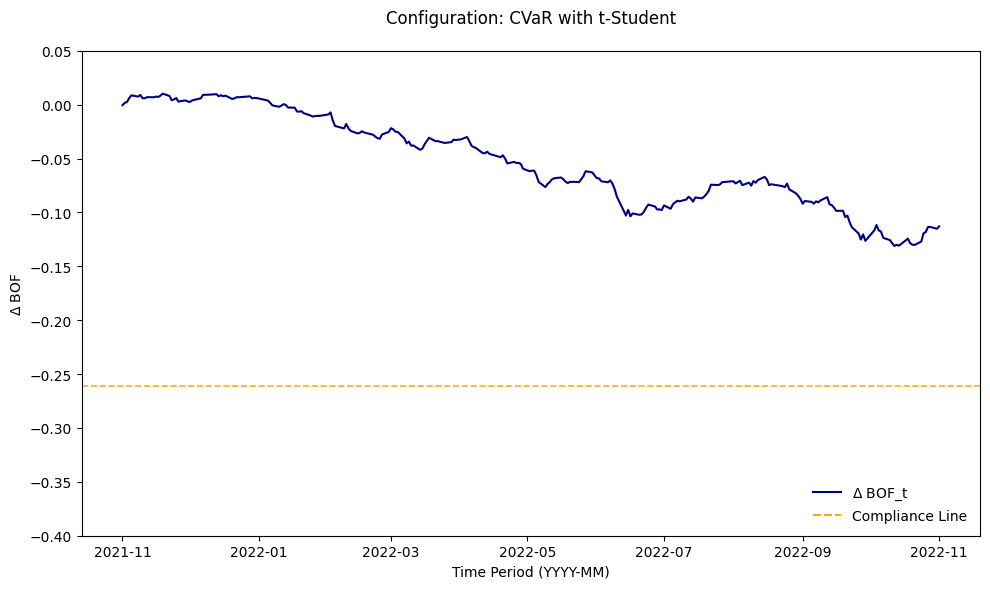

--------------NEW PARETO FRONT--------------
Compliance = -0.07215918288665205


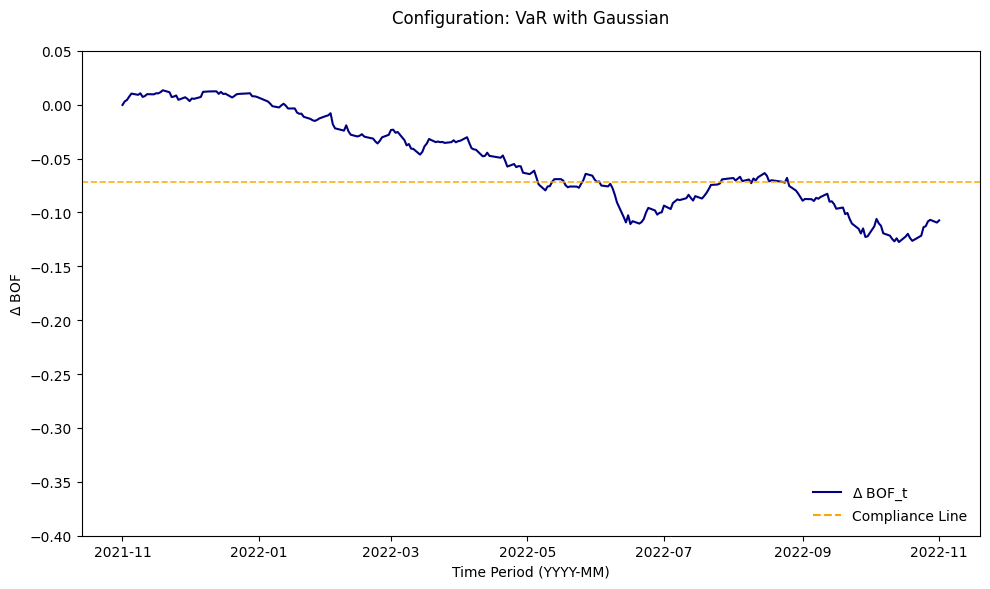

--------------NEW PARETO FRONT--------------
Compliance = -0.06976762414897619


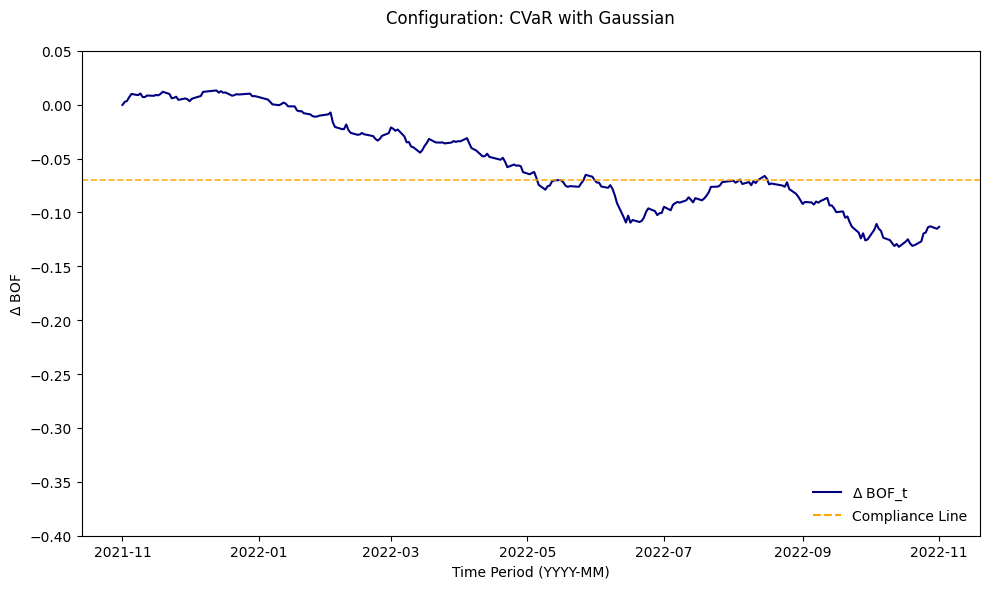

--------------NEW PARETO FRONT--------------
Compliance = -0.17786492175562163


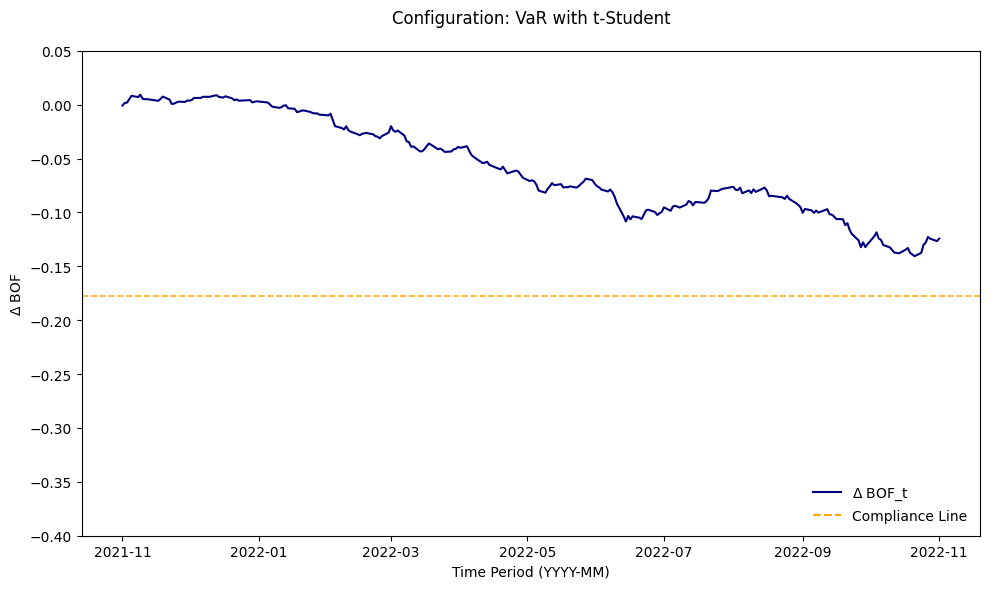

--------------NEW PARETO FRONT--------------
Compliance = -0.09092123590904647


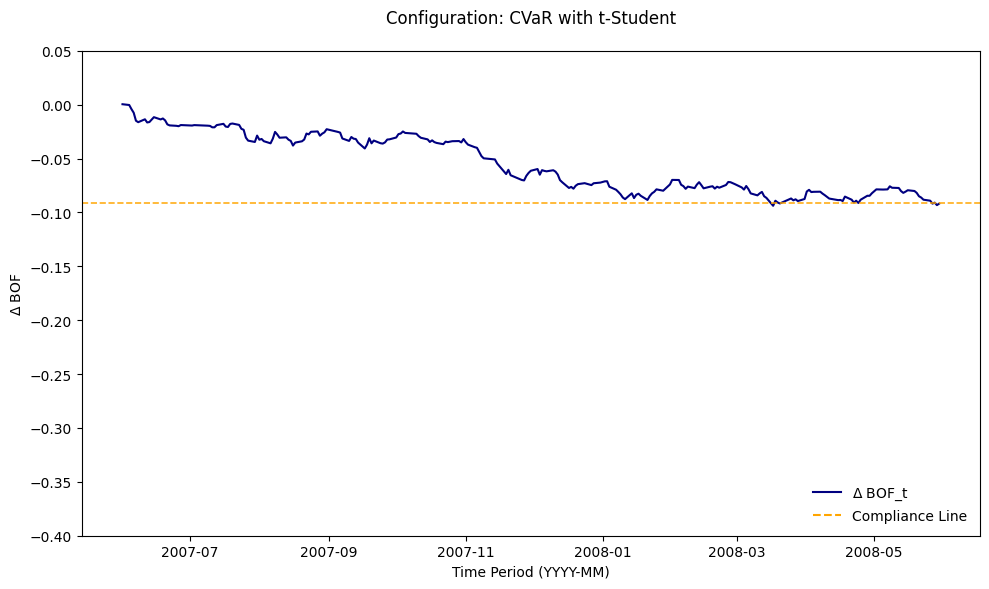

--------------NEW PARETO FRONT--------------
Compliance = -0.018081984568711053


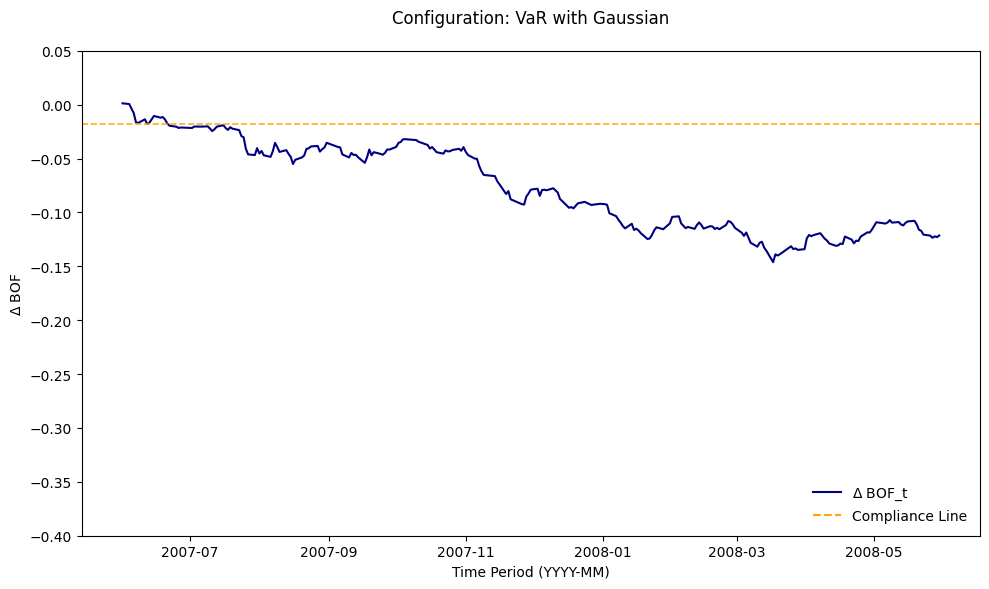

--------------NEW PARETO FRONT--------------
Compliance = -0.03178295160196071


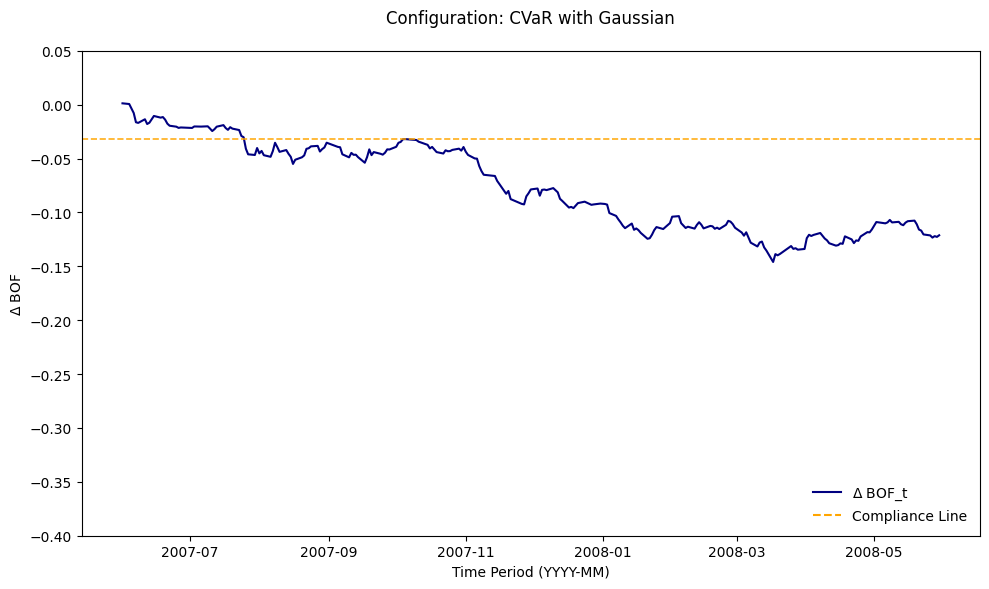

--------------NEW PARETO FRONT--------------
Compliance = -0.049764457827124624


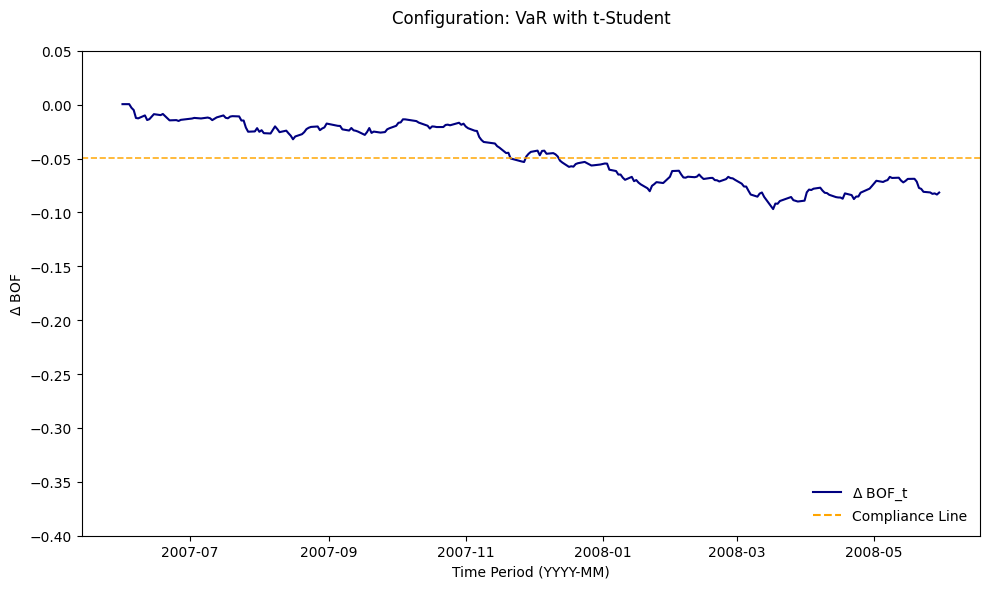

--------------NEW PARETO FRONT--------------
Compliance = -0.0802488850817056


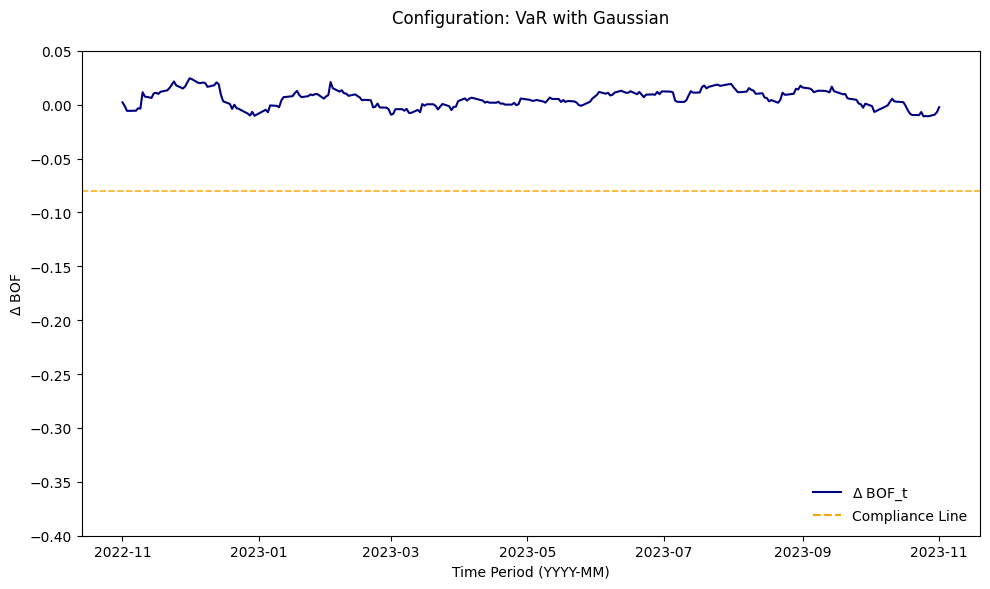

--------------NEW PARETO FRONT--------------
Compliance = -0.0997441634867825


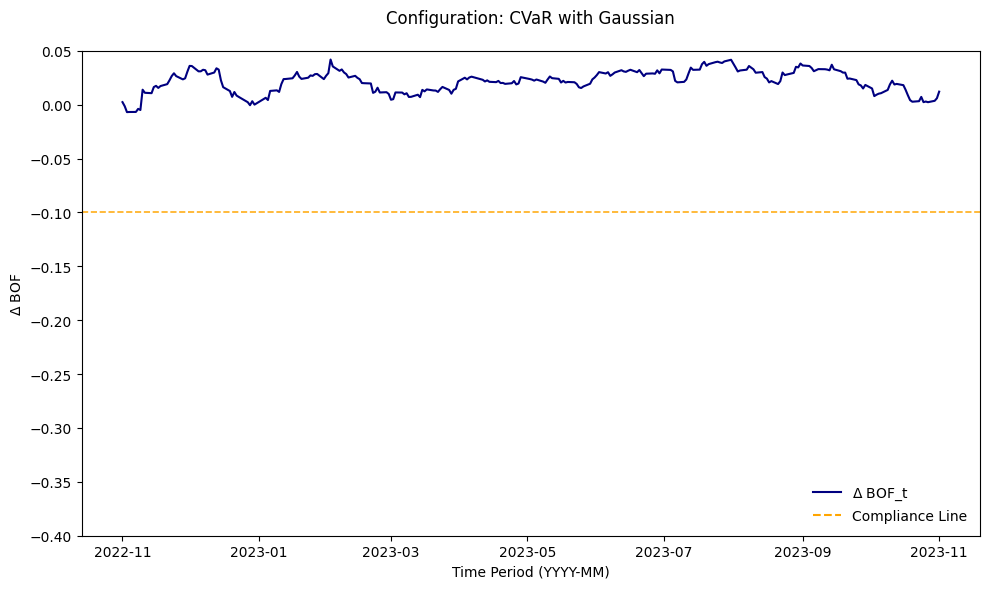

--------------NEW PARETO FRONT--------------
Compliance = -0.1814326257964289


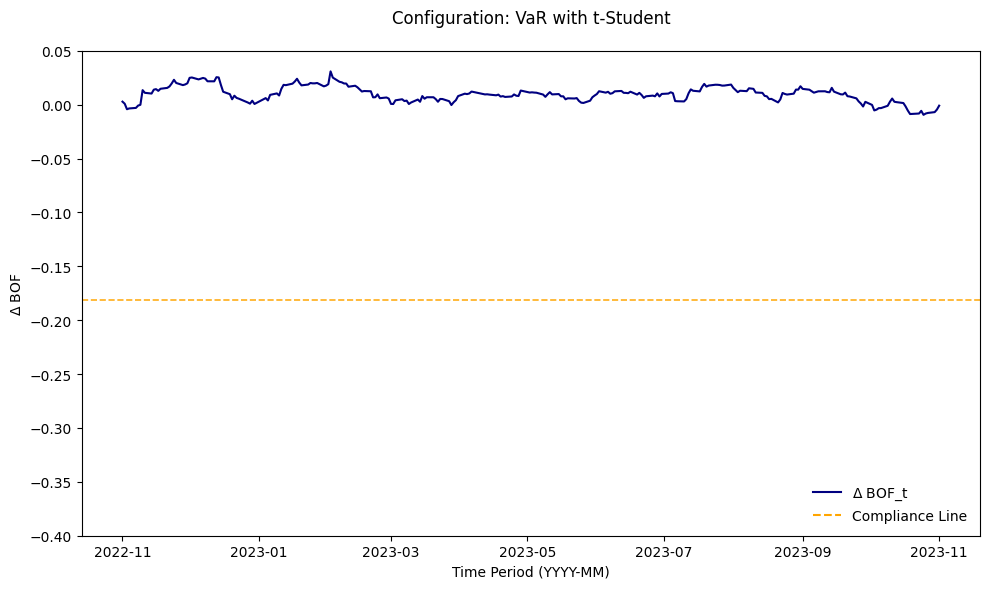

In [11]:
for pareto_front in pareto_fronts:
    print("--------------NEW PARETO FRONT--------------")
    i = 0
    for portfolio in pareto_front:
        i += 1
        bof_changes = []

        weights = portfolio["weights"]
        period = portfolio["period"]
        start_date = pd.to_datetime(period[0], format='%Y-%m-%d', errors='coerce')
        end_date = pd.to_datetime(period[1], format='%Y-%m-%d', errors='coerce')

        # Filter data for this period
        filtered_df = df[(df.index >= str(start_date)) & (df.index <= str(end_date))]
        
        assets_0 = 1000000
        liabilities_0 = assets_0 * frac_liabilities

        # Loop over each day in the filtered period
        for current_date in filtered_df.index:
            # Filter data up to the current date
            current_data = filtered_df.loc[:current_date]

            # Calculate cumulative returns for the portfolio
            stock_returns = current_data
            eonia_returns = current_data["EONIA"]
            portfolio_returns = np.dot(stock_returns.values, weights)
            cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1

            # Calculate cumulative liability growth
            cumulative_liability_growth = np.prod(1 + eonia_returns) - 1

            # Calculate BOF change
            change_in_bof = (cumulative_portfolio_return * assets_0) - (cumulative_liability_growth * liabilities_0)

            # Making into percentage
            change_in_bof = change_in_bof / 1000000

            # Append BOF change for each day
            bof_changes.append({
                "time": current_date,
                "final_bof": change_in_bof,
                "risk_measure": portfolio["risk_measure"]
            })

        # Convert to DataFrame for easy visualization
        bof_changes_df = pd.DataFrame(bof_changes)

        # Plot BOF changes over time
        plt.figure(figsize=(10, 6))
        plt.plot(
            bof_changes_df["time"],
            bof_changes_df["final_bof"],
            color="navy", linewidth=1.5, label=r"$\Delta$ BOF_t"
        )

        # Add the compliance line
        compliance = -portfolio['SCR_risk'] / 1000000
        print("Compliance =", compliance)
        plt.axhline(compliance, color="orange", linestyle="--", linewidth=1.2, alpha=0.9, label="Compliance Line")

        # Set y-axis limits and format
        plt.ylim(-0.4, 0.05)
        plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))

        # Add a styled informational box
        
        info_text = "\n".join([f"{key}: {value}" for key, value in portfolio.items() if key not in ["weights", "expected_return", "period"]])
        '''
        plt.gcf().text(
            0.8, 0.75, info_text, fontsize=10, fontfamily='serif',
            bbox=dict(
                facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8
            )
                )'''
        
        risk_measure_mapping = {
            "var": "VaR",
            "cvar": "CVaR"
        }

        distribution_mapping = {
            "normal": "Gaussian",
            "tstudent": "t-Student"
        }

        # Populate the info dictionary with formatted values
        info = {
            "Risk Measure": risk_measure_mapping.get(portfolio["risk_measure"].lower(), portfolio["risk_measure"]),
            "Distribution": distribution_mapping.get(portfolio["distribution"].lower(), portfolio["distribution"])
        }

        info_legend_text = "\n".join([f"{key}: {value}" for key, value in info.items()])


        plt.legend(
        handles=[
            plt.Line2D([], [], color='navy', label=r"$\Delta$ BOF_t"),
            plt.Line2D([], [], color='orange', linestyle="--", label="Compliance Line"),
        ],
        loc='lower right', frameon=False, fontsize=10
        )

        title_text = f"Configuration: {info['Risk Measure']} with {info['Distribution']}"

        # Set the title
        plt.title(title_text, pad=20)
        plt.xlabel("Time Period (YYYY-MM)")
        plt.ylabel(r"$\Delta$ BOF")

        # Move legend inside the plot
        #plt.legend(loc='lower right', frameon=False)

        # Ensure layout fits well
        plt.tight_layout()
        plt.show()
